# Imports:

In [1]:
!pip install tensorflow_addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, preprocessing, losses
import matplotlib.pyplot as plt
from os import listdir, mkdir, path
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
# from google.colab import files

# Load Coin Dataset:

In [15]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# dataset_dir = '/content/drive/MyDrive/images/'
# model_dir = '/content/drive/MyDrive/coin_classifier_model/'

# Local
dataset_dir = 'images/'
model_dir = 'coin_classifier_model/'

In [25]:
class RandomBrightness(layers.Layer):
  def __init__(self, delta, **kwargs):
    super(RandomBrightness, self).__init__(**kwargs)
    self.delta = delta

  def __call__(self, images, **kwargs):
    def random_brightness(image):
      return tf.image.random_brightness(image, self.delta)
    images = tf.map_fn(random_brightness, images)
    return tf.clip_by_value(images, 0, 1)

class RandomContrast(layers.Layer):
  def __init__(self, range, **kwargs):
    super(RandomContrast, self).__init__(**kwargs)
    self.range = range

  def __call__(self, images, **kwargs):
    def random_contrast(image):
      return tf.image.random_contrast(image, self.range[0], self.range[1])
    images = tf.map_fn(random_contrast, images)
    return tf.clip_by_value(images, 0, 1)

augment = models.Sequential([
  layers.RandomZoom((0, 0.2), fill_mode="constant", fill_value=1),
  layers.RandomRotation(0.05, fill_mode="constant", fill_value=1),
  layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=1),
  RandomBrightness(0.2),
  RandomContrast((0.8, 1))
])

In [34]:
batch_size = 64
img_size = 128

labels = listdir(dataset_dir)
labels.sort()

if '.DS_Store' in labels:
  labels.remove('.DS_Store')

dataset = preprocessing.image_dataset_from_directory(
  dataset_dir,
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_size, img_size),
  shuffle=True,
)
dataset = dataset.map(lambda image, label: (image / 255.0, label))
datasets = [dataset.map(lambda image, label: (augment(image), label)) for _ in range(9)]
for ds in datasets:
  dataset = dataset.concatenate(ds)

Found 4050 files belonging to 83 classes.


# Display Coin Images:

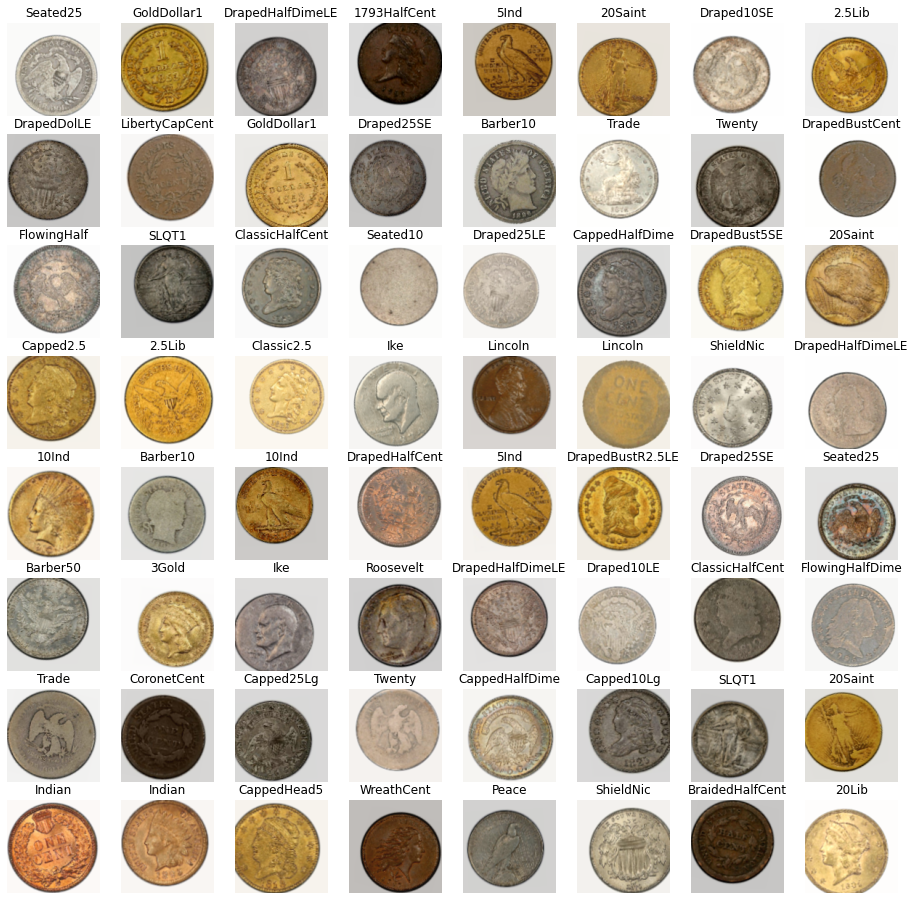

In [44]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = next(dataset.as_numpy_iterator())
X_batch = np.clip(augment(X_batch), 0, 1)
for i in range(batch_size):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[y_batch[i]])

# Create CNN:

In [45]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(119),
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)       

# Train Model:

In [78]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(dataset, epochs=10)

Epoch 1/10
640/640 [==============================] - 184s 287ms/step - loss: 0.6286 - accuracy: 0.7929
Epoch 2/10
640/640 [==============================] - 189s 294ms/step - loss: 0.5633 - accuracy: 0.8143
Epoch 3/10
640/640 [==============================] - 180s 280ms/step - loss: 0.5506 - accuracy: 0.8176
Epoch 4/10
640/640 [==============================] - 191s 297ms/step - loss: 0.4920 - accuracy: 0.8353
Epoch 5/10
640/640 [==============================] - 184s 288ms/step - loss: 0.4821 - accuracy: 0.8401
Epoch 6/10
 23/640 [>.............................] - ETA: 33s - loss: 0.1443 - accuracy: 0.9538

KeyboardInterrupt: 

# Save/Load Model:

In [96]:
model.save(model_dir)
# model = models.load_model(model_dir)

INFO:tensorflow:Assets written to: coin_classifier_model/assets


# Test Images:

In [79]:
correct = {}
total = {}
for i in range(len(labels)):
  correct[i] = 0
  total[i] = 0
for X, y in dataset:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = y[i].numpy()
    if pred == true:
      correct[true] += 1
    total[true] += 1
for label, count in correct.items():
  acc = count / total[label]
  print('%s: %.2f' % (labels[label], acc))

10Ind: 1.00
10Lib: 0.88
1793HalfCent: 0.90
2.5Ind: 0.84
2.5Lib: 0.95
20Lib: 0.94
20Saint: 0.99
3CentNic: 0.99
3CentSil: 0.95
3Gold: 0.93
5Ind: 0.96
5Lib: 0.95
Barber10: 0.96
Barber25: 0.93
Barber50: 0.81
BraidedCent: 0.94
BraidedHalfCent: 0.99
Buffalo: 1.00
Capped10Lg: 0.90
Capped2.5: 0.86
Capped25Lg: 0.88
Capped50: 0.90
CappedBust5: 0.95
CappedHalfDime: 0.95
CappedHead5: 0.84
ChainCent: 0.93
Classic2.5: 0.81
Classic5: 0.97
ClassicCent: 0.94
ClassicHalfCent: 0.91
CoronetCent: 0.97
Draped10LE: 0.82
Draped10SE: 0.85
Draped25LE: 0.83
Draped25SE: 0.88
Draped50LE: 0.86
Draped50SE: 0.93
DrapedBust10LE: 0.86
DrapedBust10SE: 0.90
DrapedBust5LE: 0.82
DrapedBust5SE: 0.78
DrapedBustCent: 0.70
DrapedBustR2.5LE: 0.82
DrapedDolLE: 0.89
DrapedHalfCent: 0.92
DrapedHalfDime: 0.61
DrapedHalfDimeLE: 0.79
FlowingDol: 0.95
FlowingHalf: 0.73
FlowingHalfDime: 0.91
Flying: 0.98
Franklin: 0.99
GoldDollar1: 1.00
GoldDollar2: 0.88
GoldDollar3: 0.85
Ike: 0.87
Indian: 0.98
Jefferson: 0.99
Kennedy: 0.97
LibNic: 0.9

1: 3CentNic
2: Seated-Half-Dime
3: Seated10
4: Twenty
5: GoldDollar1


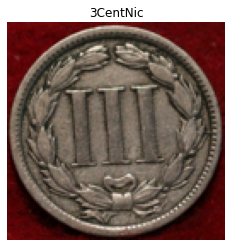

In [95]:
img = Image.open('test_images/three_cent_nickel_r.jpg')
img = img.resize(size=(img_size, img_size))
img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)

# X, y = next(dataset.as_numpy_iterator())
# img_data = X[0]
# print('True: %s' % labels[y[0]])

img_dataset = tf.data.Dataset.from_tensors([img_data])
prediction = model.predict(img_dataset)[0]
plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)
ranked = np.argsort(prediction)
print('1: %s' % labels[ranked[-1]])
print('2: %s' % labels[ranked[-2]])
print('3: %s' % labels[ranked[-3]])
print('4: %s' % labels[ranked[-4]])
print('5: %s' % labels[ranked[-5]])